# Baseline Rhythmic Assessment System

### This notebook aims at the creation of a simple baseline rhythmic assessment system which exemplifies the usage of the MAST Rhythmic subset

### Starting by creating some auxiliar functions to handle the stored data and functions that prepare the raw dataset to feed Machine Learning classifiers. The model features are the edit distance (aka Levenshtein distance) and the beat difference whereas the targets are the average of grades provided by annotators and binary assessments (fail or pass) according to these grades

In [155]:
import os
import sklearn.datasets
import numpy as np

from statistics import median

DATA_FOLDER = "../data/"

### storage handlers ###
def get_audio_index(file, performance_type):
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), 'list%ss' % performance_type)
    with open(file_path, 'r') as list_files:
        files = [x.strip() for x in list_files.readlines()]
        return files.index(file)
    
def get_info(index, performance_type, info_file_format):   
    file_path = os.path.join(DATA_FOLDER, 'Only %ss' % performance_type.capitalize(), info_file_format.format(performance_type.capitalize()))
    
    with open(file_path, 'r') as infos:
        info = infos.readlines()[index]
        return [int(x) for x in info.split()]
  

### distance measures for binary vectors ###
def levenshtein(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def beat_difference(s1, s2):
    return abs(s1.count(1) - s2.count(1))
    
def get_class_for_performance(audio_name, multiclass=True):
    annotations = []
    for (dirpath, dirnames, filenames) in os.walk(os.path.join(DATA_FOLDER, "Performances Annotations")):
        for file_name in filenames:
            if file_name == 'listfiles.txt':
                pass
            else:
                with open(os.path.join(dirpath, file_name), 'r') as annotator_file:
                    for annotation in annotator_file.readlines():
                        annotation = annotation.strip()
                        if audio_name in annotation:
                            grade = int(annotation.split()[1].split('Grade:')[1])
                            annotations.append(grade)
                            
    # the average grade across all annotations is calculated according to the following:
    # "leave the max and min value out and compute an average of the rest"
    annotations.remove(max(annotations))
    annotations.remove(min(annotations))
    average_grade = sum(annotations)/len(annotations)
    if multiclass:
        return average_grade
    # the binary class of a performance is 1 (accepted) if mode is 3 or higher. 0 (rejected) otherwise
    return 1 if average_grade >= 3 else 0
  
def load_rhythmic_performances():
    features = []
    target_multiclass = []
    target_binary = []
    
    DISTANCE_FUNCTIONS = [levenshtein, beat_difference]
    
    with open('../data/Performances Annotations/listfiles.txt', 'r') as list_of_files,\
         open('../data/Only Performances/listperformances', 'r') as performances_file,\
         open('../data/Only Performances/MAST Onsets [Performances] [BINS]', 'r') as performances_onsets,\
         open('../data/Only References/listreferences', 'r') as references_file,\
         open('../data/Only References/MAST Onsets [References] [BINS]', 'r') as references_onsets:        
        
        for performance in list_of_files.readlines():
            performance = performance.strip()
            index = get_audio_index(performance,'performance')
            
            performance_bins = get_info(index, 'performance', 'MAST Onsets [{}s] [BINS]')
            reference_bins = get_info(index, 'reference', 'MAST Onsets [{}s] [BINS]')              
            
            # model features
            features.append([distance_function(performance_bins, reference_bins) for distance_function in DISTANCE_FUNCTIONS])         
            
            # model targets
            target_multiclass.append(get_class_for_performance(performance))
            target_binary.append(get_class_for_performance(performance, multiclass=False))
            
    return sklearn.datasets.base.Bunch(data=np.asarray(features), target_multiclass=np.asarray(target_multiclass), target_binary=np.asarray(target_binary))   

### Next, we use the prepared data to train/test a Logistic Regression model for binary classification and a Linear Regression model for checking the mean average error. We are using a 5-fold cross validation (i.e. test size: 20%). The learning curves ar mean error are shown below.

Absolute mean error (multi-class): 0.625061859102


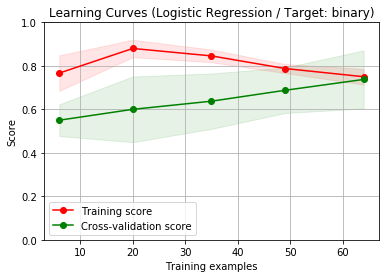

In [154]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score
from sklearn.metrics import mean_squared_error


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# loading rhythmic dataset
mast = load_rhythmic_performances()
X, y_b, y_m = mast.data, mast.target_binary, mast.target_multiclass

# setting up a 5-fold cross validation for estimators
cv = KFold(n_splits=5, random_state=0, shuffle=True)

title = r"Learning Curves (Logistic Regression / Target: binary)"
logit_reg_estimator = LogisticRegression()
plot_learning_curve(logit_reg_estimator, title, X, y_b, (0, 1), cv=cv)

linear_reg_estimator = LinearRegression()

cross_val_errors = cross_val_score(linear_regression, X, y_m, scoring='neg_mean_absolute_error', cv=cv)
print("Absolute mean error (multi-class):", abs(sum(cross_val_errors)/len(cross_val_errors)))